In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, accuracy_score, roc_auc_score,
                             average_precision_score, confusion_matrix)
from scipy.stats import norm

# Load and preprocess data
print("Loading and preprocessing data...")
rf_dataset = pd.read_csv('/root/DATA/cleaned_final_dataset.csv')
rf_dataset = rf_dataset.drop(columns=['subject_id', 'icustay_id', 'hadm_id'], errors='ignore')
X_features_rf = pd.get_dummies(rf_dataset.drop(columns=['expire_flag']), drop_first=True)
y_target_rf = rf_dataset['expire_flag']
print("Data loaded and preprocessed.")

# Split data
print("Splitting data into training and testing sets...")
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_features_rf, y_target_rf, test_size=0.2, stratify=y_target_rf, random_state=42
)

# Standardize features
print("Standardizing features...")
scaler_rf = StandardScaler()
X_train_scaled_rf = scaler_rf.fit_transform(X_train_rf)
X_test_scaled_rf = scaler_rf.transform(X_test_rf)

# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [100],
    'max_features': [10, 20],
    'min_samples_split': [10],
    'min_samples_leaf': [1, 2],
    'max_depth': [10, None],
    'class_weight': [{0: 0.3, 1: 0.7}]
}

# Manual grid search with cross-validation
print("Starting manual grid search...")
best_score = -np.inf
best_params = None
for params in ParameterGrid(param_grid_rf):
    current_model = RandomForestClassifier(random_state=42, **params)
    scores = cross_val_score(current_model, X_train_scaled_rf, y_train_rf, cv=5, scoring='roc_auc')
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
    print(f"Params tested: {params}, Mean AUROC Score: {mean_score:.4f}")

print(f"Best Hyperparameters: {best_params}")
print(f"Best AUROC Score (Cross-Validation): {best_score:.4f}")

# Train and predict with best model
print("Training and predicting with the best model...")
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train_scaled_rf, y_train_rf)
y_train_pred_rf = best_rf_model.predict(X_train_scaled_rf)
y_test_pred_rf = best_rf_model.predict(X_test_scaled_rf)
y_train_prob_rf = best_rf_model.predict_proba(X_train_scaled_rf)[:, 1]
y_test_prob_rf = best_rf_model.predict_proba(X_test_scaled_rf)[:, 1]

# Bootstrapping for AUROC confidence intervals
print("Calculating AUROC confidence intervals using bootstrapping...")
def bootstrap_metric_ci(metric_func, y_true, y_prob, n_bootstraps=1000):
    bootstrapped_scores = []
    np.random.seed(42)
    for i in range(n_bootstraps):
        indices = np.random.choice(len(y_true), len(y_true))
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        score = metric_func(y_true.iloc[indices], y_prob[indices])
        bootstrapped_scores.append(score)
    return compute_ci(bootstrapped_scores)

def compute_ci(scores, alpha=0.95):
    mean_score = np.mean(scores)
    std_dev = np.std(scores)
    z_score = norm.ppf(1 - (1 - alpha) / 2)
    ci_lower = mean_score - z_score * (std_dev / np.sqrt(len(scores)))
    ci_upper = mean_score + z_score * (std_dev / np.sqrt(len(scores)))
    return f"{mean_score:.4f} ({ci_lower:.4f}, {ci_upper:.4f})"

train_auroc_ci = bootstrap_metric_ci(roc_auc_score, y_train_rf, y_train_prob_rf)
test_auroc_ci = bootstrap_metric_ci(roc_auc_score, y_test_rf, y_test_prob_rf)
train_auprc = average_precision_score(y_train_rf, y_train_prob_rf)
test_auprc = average_precision_score(y_test_rf, y_test_prob_rf)
train_f1 = f1_score(y_train_rf, y_train_pred_rf)
test_f1 = f1_score(y_test_rf, y_test_pred_rf)
train_accuracy = accuracy_score(y_train_rf, y_train_pred_rf)
test_accuracy = accuracy_score(y_test_rf, y_test_pred_rf)

# Sensitivity and Specificity
print("Calculating sensitivity and specificity...")
def calculate_sensitivity_specificity(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

confusion_train_rf = confusion_matrix(y_train_rf, y_train_pred_rf)
confusion_test_rf = confusion_matrix(y_test_rf, y_test_pred_rf)
train_sensitivity_rf, train_specificity_rf = calculate_sensitivity_specificity(confusion_train_rf)
test_sensitivity_rf, test_specificity_rf = calculate_sensitivity_specificity(confusion_test_rf)

# Summary table
print("Creating summary table...")
summary_data_rf = {
    "Metric": ["AUROC (95% CI)", "AUPRC", "F1 Score", "Accuracy", "Sensitivity", "Specificity"],
    "Training cohort": [train_auroc_ci, f"{train_auprc:.4f}", f"{train_f1:.4f}", f"{train_accuracy:.4f}", f"{train_sensitivity_rf:.4f}", f"{train_specificity_rf:.4f}"],
    "Testing cohort": [test_auroc_ci, f"{test_auprc:.4f}", f"{test_f1:.4f}", f"{test_accuracy:.4f}", f"{test_sensitivity_rf:.4f}", f"{test_specificity_rf:.4f}"]
}

summary_df_rf = pd.DataFrame(summary_data_rf)
print(summary_df_rf)


Loading and preprocessing data...
Data loaded and preprocessed.
Splitting data into training and testing sets...
Standardizing features...
Starting manual grid search...
Params tested: {'class_weight': {0: 0.3, 1: 0.7}, 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}, Mean AUROC Score: 0.7590
Params tested: {'class_weight': {0: 0.3, 1: 0.7}, 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}, Mean AUROC Score: 0.7600
Params tested: {'class_weight': {0: 0.3, 1: 0.7}, 'max_depth': 10, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}, Mean AUROC Score: 0.7548
Params tested: {'class_weight': {0: 0.3, 1: 0.7}, 'max_depth': 10, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}, Mean AUROC Score: 0.7562
Params tested: {'class_weight': {0: 0.3, 1: 0.7}, 'max_depth': None, 'max_features': 10, 'min_samples_


Classification Report - Training Set:
              precision    recall  f1-score   support

          No       0.88      0.63      0.73      9588
         Yes       0.61      0.87      0.72      6447

    accuracy                           0.72     16035
   macro avg       0.74      0.75      0.72     16035
weighted avg       0.77      0.72      0.73     16035



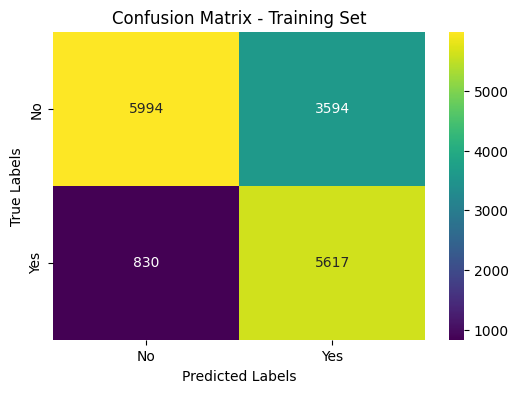

In [3]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, accuracy_score, roc_auc_score,
                             average_precision_score, confusion_matrix, classification_report)
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# 使用最佳参数训练模型并预测
# best_rf_model 已定义
best_rf_model.fit(X_train_scaled_rf, y_train_rf)
y_train_pred_rf = best_rf_model.predict(X_train_scaled_rf)
y_test_pred_rf = best_rf_model.predict(X_test_scaled_rf)

# 1. 计算并打印训练集的分类报告
print("\nClassification Report - Training Set:")
train_report_rf = classification_report(y_train_rf, y_train_pred_rf, target_names=['No', 'Yes'])
print(train_report_rf)

# 2. 计算训练集的混淆矩阵
confusion_train_rf = confusion_matrix(y_train_rf, y_train_pred_rf)

# 3. 绘制训练集的混淆矩阵函数
def plot_confusion_matrix_rf_train(cm_rf_train):
    labels_rf = ['No', 'Yes']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_rf_train, annot=True, fmt='.0f', cmap='viridis',
                xticklabels=labels_rf, yticklabels=labels_rf)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Training Set')
    plt.show()

# 4. 绘制训练集的混淆矩阵
plot_confusion_matrix_rf_train(confusion_train_rf)



Classification Report - Testing Set:
              precision    recall  f1-score   support

          No       0.81      0.58      0.68      2397
         Yes       0.56      0.79      0.66      1612

    accuracy                           0.67      4009
   macro avg       0.69      0.69      0.67      4009
weighted avg       0.71      0.67      0.67      4009



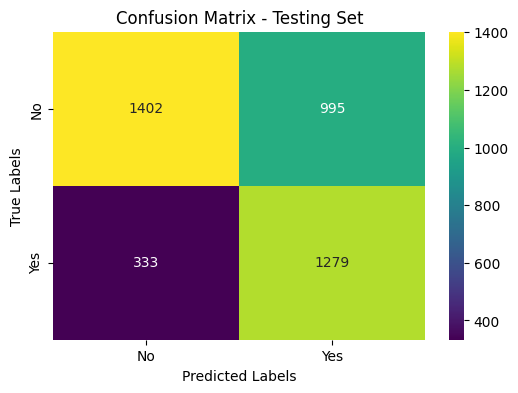

In [4]:
# 5. 计算并打印测试集的分类报告
print("\nClassification Report - Testing Set:")
test_report_rf = classification_report(y_test_rf, y_test_pred_rf, target_names=['No', 'Yes'])
print(test_report_rf)

# 6. 计算测试集的混淆矩阵
confusion_test_rf = confusion_matrix(y_test_rf, y_test_pred_rf)

# 7. 绘制测试集的混淆矩阵函数
def plot_confusion_matrix_rf_test(cm_rf_test):
    labels_rf = ['No', 'Yes']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_rf_test, annot=True, fmt='.0f', cmap='viridis',
                xticklabels=labels_rf, yticklabels=labels_rf)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Testing Set')
    plt.show()

# 8. 绘制测试集的混淆矩阵
plot_confusion_matrix_rf_test(confusion_test_rf)


In [17]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# 1. Initialize the SHAP Explainer for the trained Random Forest model
explainer_rf = shap.TreeExplainer(best_rf_model)

# 2. Calculate SHAP values for the test dataset
shap_values_rf = explainer_rf.shap_values(X_test_scaled_rf)

# 3. Verify the shape of SHAP values
print(f"SHAP values shape: {shap_values_rf[1].shape}")  # (21, 2)

# 4. Calculate mean absolute SHAP values across all classes (axis=0 for samples, axis=2 for classes)
mean_abs_shap_values_rf = np.mean(np.abs(shap_values_rf), axis=(0, 2))

# 5. Verify the shape (should now match the number of features)
print(f"Mean Absolute SHAP Values Shape: {mean_abs_shap_values_rf.shape}")

# 6. Create a DataFrame with feature names and their mean absolute SHAP values
df_shap_rf = pd.DataFrame({
    'feature': X_test_rf.columns,
    'mean_abs_shap_value': mean_abs_shap_values_rf
})

# 7. Sort the DataFrame by mean absolute SHAP values in descending order
df_shap_rf = df_shap_rf.sort_values('mean_abs_shap_value', ascending=False)

# 8. Display the top 10 most important features
print("Top 10 Features by Mean Absolute SHAP Value:")
print(df_shap_rf.head(10))


SHAP values shape: (21, 2)
Mean Absolute SHAP Values Shape: (21,)
Top 10 Features by Mean Absolute SHAP Value:
                                         feature  mean_abs_shap_value
0                                      age_years             0.120418
15       admission_location_EMERGENCY ROOM ADMIT             0.042770
6                              bloodureanitrogen             0.037069
4                                      gcsverbal             0.025703
14  admission_location_CLINIC REFERRAL/PREMATURE             0.023566
16  admission_location_PHYS REFERRAL/NORMAL DELI             0.022702
3                                       gcsmotor             0.021135
12                      admission_type_EMERGENCY             0.014994
9                                      platelets             0.014389
1                                        glucose             0.013026


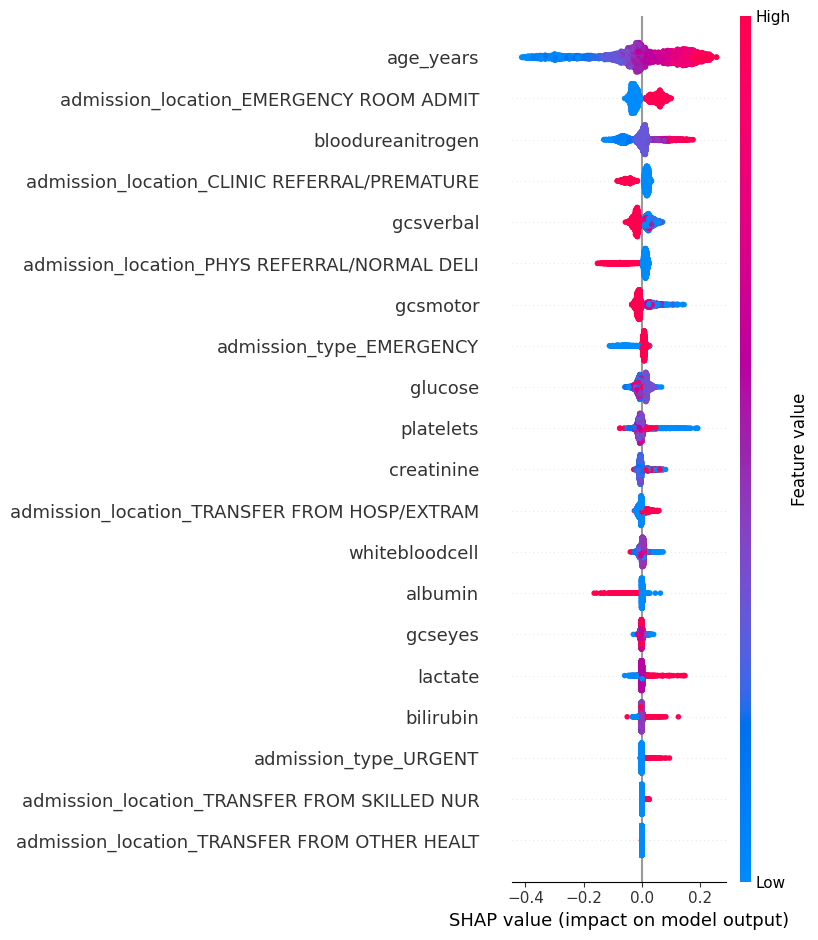

In [15]:
# 选择正类的 SHAP 值（假设第二个维度对应于正类）
shap_values_positive_class = shap_values[:, :, 1]

# 生成 SHAP 摘要图 (Summary Plot)
plt.figure()
shap.summary_plot(shap_values_positive_class, X_test_rf, plot_type="dot", show=True)


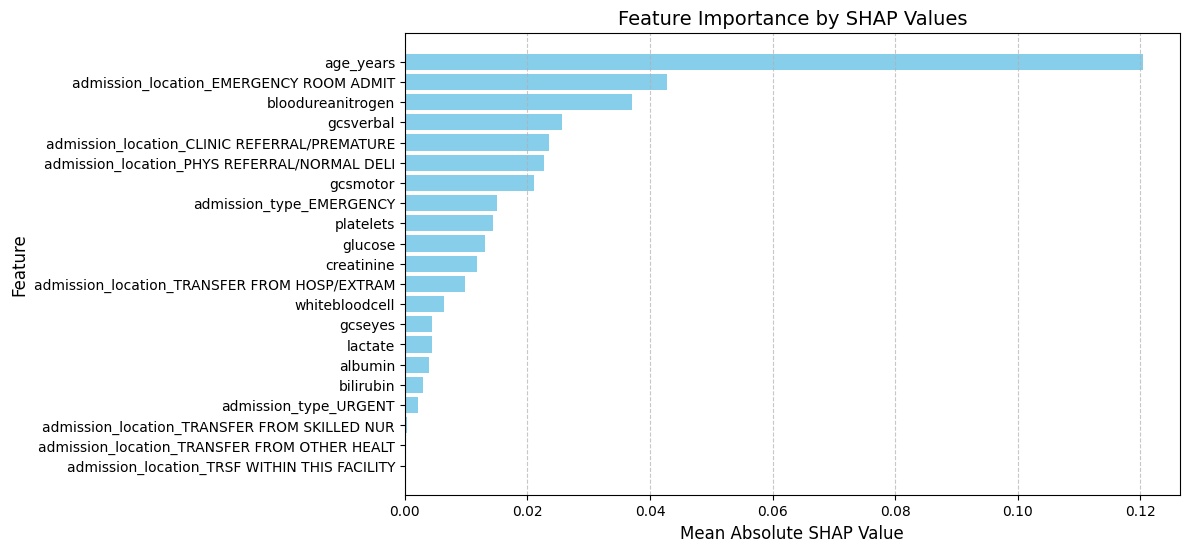

In [18]:
# 9. Plot the SHAP summary plot
plt.figure(figsize=(10, 6))
plt.barh(df_shap_rf['feature'], df_shap_rf['mean_abs_shap_value'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance by SHAP Values', fontsize=14)
plt.gca().invert_yaxis()  # 将特征顺序从高到低排列
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 10. Display the plot
plt.show()


In [19]:
# Save the predicted probabilities and true labels for the training and testing sets for Random Forest
train_results_rf = pd.DataFrame({
    "True_Label": y_train_rf,
    "Predicted_Probability": y_train_prob_rf
})

test_results_rf = pd.DataFrame({
    "True_Label": y_test_rf,
    "Predicted_Probability": y_test_prob_rf
})

# Save data to CSV files
train_results_rf.to_csv('/root/DATA/train_results_random_forest.csv', index=False)
test_results_rf.to_csv('/root/DATA/test_results_random_forest.csv', index=False)

print("Predicted results for the training and testing sets for Random Forest have been saved to CSV files.")


Predicted results for the training and testing sets for Random Forest have been saved to CSV files.
